In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import arxiv
import matplotlib.pyplot as plt
from random import randint


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, classification_report
from itertools import product
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

from node2vec import Node2Vec as n2v

generate Facebook network

43.69101262688784
Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


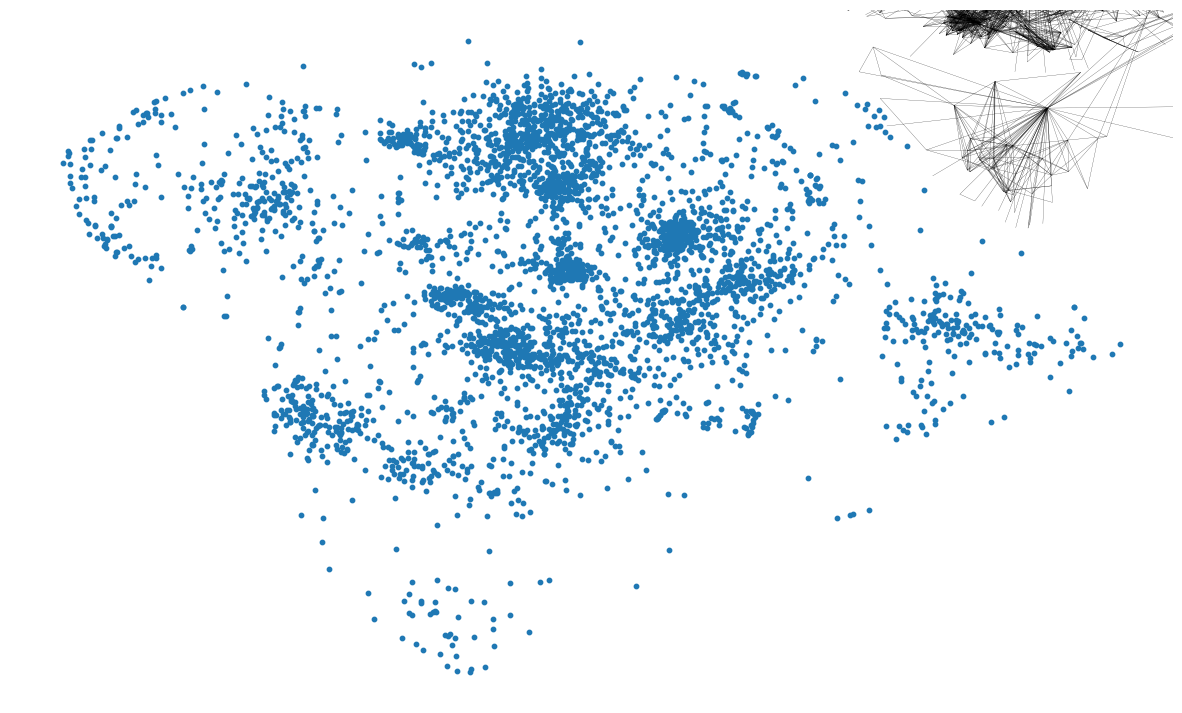

In [4]:
def generate_network(df, node_col = 'person_id', edge_col = 'main_topic'):
    '''
    This function will generate a article to article network given an input DataFrame.
    It will do so by creating an edge_dictionary where each key is going to be a node
    referenced by unique values in node_col and the values will be a list of other nodes
    connected to the key through the edge_col.
    
    params:
        df (DataFrame) : The dataset which holds the node and edge columns
        node_col (String) : The column name associated to the nodes of the network
        edge_col (String) : The column name associated to the edges of the network
        
    returns:
        A networkx graph corresponding to the input dataset
        
    example:
        generate_network(
            research_df,
            node_col = 'person_id',
            edge_col = 'main_topic'
        )
    '''
    edge_dct = {}
    for i,g in df.groupby(node_col):
        topics = g[edge_col].unique()
        edge_df = df[(df[node_col] != i) & (df[edge_col].isin(topics))]
        edges = list(edge_df[node_col].unique())
        edge_dct[i] = edges
    
    # create nx network
    g = nx.Graph(edge_dct, create_using = nx.MultiGraph)
    return g

# research_df = pd.read_csv('./arxiv_data.csv')

# all_tp = research_df.explode('all_topics').copy()

# tp_nx = generate_network(
#     all_tp, 
#     node_col = 'person_id', 
#     edge_col = 'all_topics'
# )

# print(nx.info(tp_nx))

facebook = pd.read_csv(
    "./facebook_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"],
)
# print(facebook.head)

G = nx.from_pandas_edgelist(facebook, "start_node", "end_node")

pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

mean_degree = np.mean([d for _, d in G.degree()]) #TODO: dim of node2vec should be based on avg. degree of the network.ie. 44.
print(mean_degree)
print(nx.info(G))

Generate Embeddings using node2vec

In [5]:
g_emb = n2v(G, dimensions=16)

WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

mdl = g_emb.fit(
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

# create embeddings dataframe
emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in G.nodes()],
        index = G.nodes
    )
)

print(emb_df.head())

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:48<00:00,  4.82s/it]


         0         1         2         3         4         5         6   \
0  1.374905  0.549891 -0.532557  2.391270 -0.750899 -1.530436  0.671112   
1  0.460891 -0.929547 -0.098888  2.584598  0.727334  0.527890  0.382005   
2  0.103251 -1.012030 -1.175768  2.400038 -0.763730 -0.904126  1.705423   
3  1.374835  0.612355 -0.578543  2.353930  1.193452 -0.001102  0.564097   
4  1.049828  0.765134 -0.074241  3.004521 -0.706168  0.503339  1.591002   

         7         8         9         10        11        12        13  \
0 -2.143964 -0.489571 -0.014553 -0.086414  2.747454 -1.058427 -0.186938   
1 -1.975040 -1.265667  0.249439 -1.561975  1.510432 -2.552197  1.042268   
2 -0.855730 -0.185141 -0.463728 -0.783689  1.834564  0.101253 -0.891881   
3 -3.079992  0.318545 -0.260445 -2.100162  1.721751  0.753308 -0.192460   
4 -1.150353 -1.538152  0.512128 -1.722296  1.921773 -0.380102  0.122669   

         14        15  
0 -0.287481  0.666671  
1 -0.774417  1.350079  
2 -1.291800  0.104584  
3 

Recommendation with Distance meausure


In [7]:
def predict_links(G, df, person_id, N):
    '''
    This function will predict the top N links a node (person_id) should be connected with
    which it is not already connected with in G.
    
    params:
        G (Netowrkx Graph) : The network used to create the embeddings
        df (DataFrame) : The dataframe which has embeddings associated to each node
        person_id (Integer) : The person you're interested 
        N (Integer) : The number of recommended links you want to return
        
    returns:
        This function will return a list of nodes the input node should be connected with.
    '''
    
    # separate target person with all others
    person = df[df.index == person_id]
    
    # potential friends are all the people which the current person doesn't have an edge connecting
    all_nodes = G.nodes()
    other_nodes = [n for n in all_nodes if n not in list(G.adj[person_id]) + [person_id]]
    potential_friends = df[df.index.isin(other_nodes)]
    
    # get similarity of current reader and all other readers
    sim = cosine_similarity(person, potential_friends)[0].tolist()
    idx = potential_friends.index.tolist()
    
    # create a similarity dictionary for this user w.r.t all other users
    idx_sim = dict(zip(idx, sim))
    idx_sim = sorted(idx_sim.items(), key=lambda x: x[1], reverse=True)
    
    recommended_friends = idx_sim[:N]
    people = [rf[0] for rf in recommended_friends]
    return people
  
predict_links(G = G, df = emb_df, person_id = 7, N = 10)

[125, 120, 117, 152, 10, 60, 146, 324, 169, 208]

Vizualize Embeddings


[]

<Figure size 640x480 with 0 Axes>

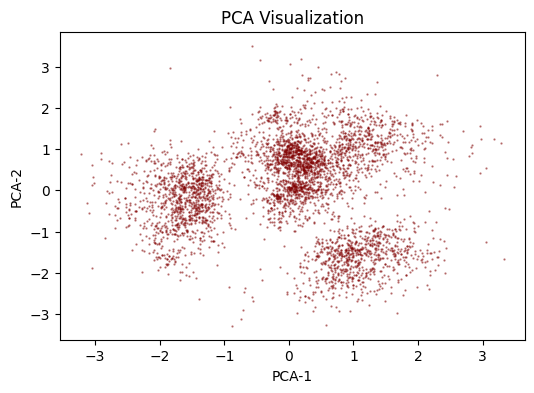

In [8]:
pca = PCA(n_components = 2, random_state = 7)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
        index = emb_df.index
    )
)
plt.clf()
fig = plt.figure(figsize=(6,4))
plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    s = 0.4,
    color = 'maroon',
    alpha = 0.5
)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Visualization')
plt.plot()